# Check Raw Episode Data

This notebook loads and displays one row of episode data from a LeRobot dataset (parquet files).

MOTIVATION : Need to verify this design behavior of writing down bytes directly in the Parquet is CORRECT behavior.


Loading LeRobot dataset: minimal_hdf5_ds/

Dataset FPS: 50
Dataset tasks: {0: 'DEBUG'}



Generating train split: 0 examples [00:00, ? examples/s]

Dataset length: 1000

Frame 0 data:

Available keys: ['observation.state', 'action', 'observation.velocity', 'observation.effort', 'observation.images.camera_left_shoulder', 'observation.images.camera_right_shoulder', 'observation.images.camera_wrist_left', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task']

State (observation.state): shape=(7,), dtype=float32
[ 0.         -0.59671855  0.53229135 -0.00306796  1.202641    0.00613592
 -0.00143166]

Action: shape=(7,), dtype=float32
[-0.00306796 -0.59825253  0.5537671   0.00153398  1.198039   -0.02454369
  0.05717295]

Velocity (observation.velocity): shape=(7,), dtype=float32
[0. 0. 0. 0. 0. 0. 0.]

Effort (observation.effort): shape=(7,), dtype=float32
[   0.        -94.15     -844.66003    56.49      -40.350002  -86.08
    0.      ]

Images:

camera_left_shoulder:
  Shape: (3, 480, 640)
  Dtype: float32
  Min: 0.0, Max: 1.0


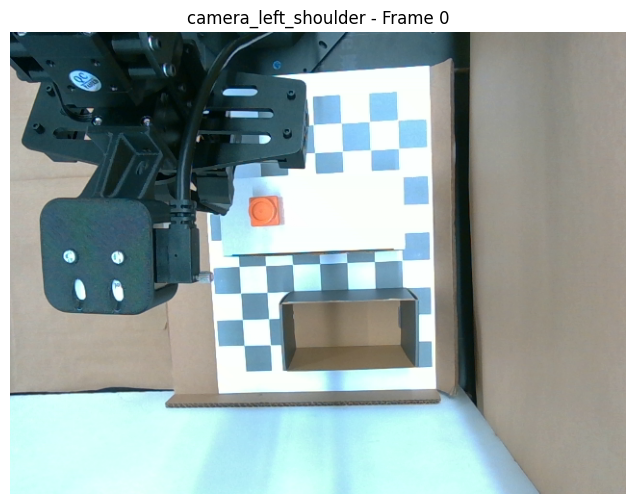


camera_right_shoulder:
  Shape: (3, 480, 640)
  Dtype: float32
  Min: 0.0, Max: 1.0


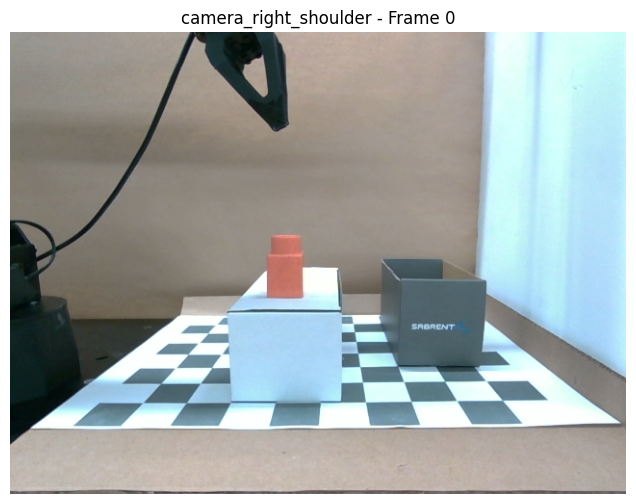


camera_wrist_left:
  Shape: (3, 480, 640)
  Dtype: float32
  Min: 0.0, Max: 1.0


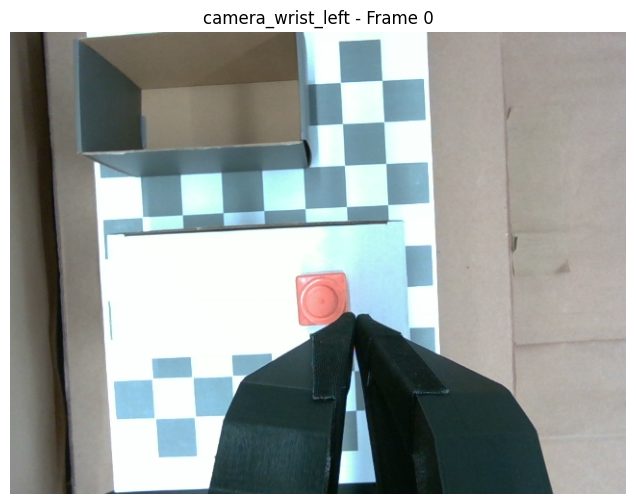


Other metadata:
timestamp: ndarray = 0.0
frame_index: ndarray = 0
episode_index: ndarray = 0
index: ndarray = 0
task_index: ndarray = 0
task: str = DEBUG


In [4]:
import lerobot.common.datasets.lerobot_dataset as lerobot_dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import pprint

# Specify the LeRobot dataset repository ID
# This can be a local repo_id or a HuggingFace repo_id like "username/dataset-name"
repo_id = "minimal_hdf5_ds/"  # Change this to your dataset repo_id!

#~/.cache/huggingface/lerobot/minimal_hdf5_ds/

print(f"Loading LeRobot dataset: {repo_id}")
print()

try:
    # Get dataset metadata
    dataset_meta = lerobot_dataset.LeRobotDatasetMetadata(repo_id)
    print(f"Dataset FPS: {dataset_meta.fps}")
    print(f"Dataset tasks: {dataset_meta.tasks}")
    print()
    
    # Load the dataset (parquet files are handled automatically)
    # For viewing raw data, we don't need delta_timestamps
    dataset = lerobot_dataset.LeRobotDataset(repo_id)
    
    print(f"Dataset length: {len(dataset)}")
    print()
    
    # Get the first row (frame) of data
    frame_idx = 0
    first_row = dataset[frame_idx]
    
    print(f"{'='*80}")
    print(f"Frame {frame_idx} data:")
    print(f"{'='*80}")
    
    # Display all keys
    print(f"\nAvailable keys: {list(first_row.keys())}")
    print()
    
    # Display state if available
    if "observation.state" in first_row:
        state = first_row["observation.state"]
        if isinstance(state, torch.Tensor):
            state = state.numpy()
        print(f"State (observation.state): shape={state.shape}, dtype={state.dtype}")
        print(state)
        print()
    
    # Display action if available
    if "action" in first_row:
        action = first_row["action"]
        if isinstance(action, torch.Tensor):
            action = action.numpy()
        print(f"Action: shape={action.shape}, dtype={action.dtype}")
        print(action)
        print()
    
    # Display velocity if available
    if "observation.velocity" in first_row:
        velocity = first_row["observation.velocity"]
        if isinstance(velocity, torch.Tensor):
            velocity = velocity.numpy()
        print(f"Velocity (observation.velocity): shape={velocity.shape}, dtype={velocity.dtype}")
        print(velocity)
        print()
    else:
        print("Velocity: Not available")
        print()
    
    # Display effort if available
    if "observation.effort" in first_row:
        effort = first_row["observation.effort"]
        if isinstance(effort, torch.Tensor):
            effort = effort.numpy()
        print(f"Effort (observation.effort): shape={effort.shape}, dtype={effort.dtype}")
        print(effort)
        print()
    else:
        print("Effort: Not available")
        print()
    
    # Display images for each camera
    print(f"{'='*80}")
    print("Images:")
    print(f"{'='*80}")
    
    # Find all image keys
    image_keys = [key for key in first_row.keys() if "observation.images." in key]
    
    if image_keys:
        for image_key in image_keys:
            camera_name = image_key.replace("observation.images.", "")
            print(f"\n{camera_name}:")
            
            img = first_row[image_key]
            # Convert tensor to numpy if needed
            if isinstance(img, torch.Tensor):
                img = img.numpy()
            
            print(f"  Shape: {img.shape}")
            print(f"  Dtype: {img.dtype}")
            print(f"  Min: {img.min()}, Max: {img.max()}")
            
            # Handle different image formats: (C, H, W) or (H, W, C)
            if img.ndim == 3:
                if img.shape[0] == 3 or img.shape[0] == 1:
                    # (C, H, W) -> (H, W, C)
                    img = np.transpose(img, (1, 2, 0))
                # Handle grayscale
                if img.shape[2] == 1:
                    img = img.squeeze(2)
            
            # Normalize to [0, 1] if needed
            if img.max() > 1.0:
                img = img / 255.0
            img = np.clip(img, 0, 1)
            
            plt.figure(figsize=(8, 6))
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(f"{camera_name} - Frame {frame_idx}")
            plt.axis('off')
            plt.show()
    else:
        print("No image keys found in dataset")
    
    # Display other metadata if available
    print(f"\n{'='*80}")
    print("Other metadata:")
    print(f"{'='*80}")
    for key in first_row.keys():
        if key not in image_keys and key not in ["observation.state", "action", "observation.velocity", "observation.effort"]:
            value = first_row[key]
            if isinstance(value, torch.Tensor):
                value = value.numpy()
            print(f"{key}: {type(value).__name__} = {value}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("\nMake sure to:")
    print("1. Set the 'repo_id' variable above to your dataset repository ID")
    print("2. The dataset should be in ~/.cache/huggingface/lerobot/<repo_id> or available on HuggingFace Hub")
